# Определение FraudScore депозита
Фиатной команде нужен AntiFraudService для получения fraudScore текущего депозита <br>для дальнейшего принятия решения об Capture или его отклонении. <br>Это поможет нам уменьшить Fraud/sell ratio.

**Некоторые показатели, указывающие на мошенников**
- Несоответствие локации
- Крупные суммы транзакций
- Частые транзакции
- Изменение типа транзакций
- Подозрительные места совершения платежей
- Необычные временные рамки
- Повторяющиеся транзакции
- Несколько неудачных попыток авторизации
- Использование заблокированных карт
<br>Важно помнить, что каждый индивидуальный показатель не обязательно указывает <br>на мошенничество - обычно это сочетание нескольких факторов вызывает тревогу.


**Описание данных тестового набора данных**
- "Kyc_citizenship" - страна выдачи документа в kyc в формате ISO2;
- "Deposit_amount_cat" - категория сумма депозита в USD. <br>(≥0 до 100 - 1я категория. ≥100 до 500 - 2я, ≥500 до 2000 - 3я, ≥2000 - 4я);
- "Deposit_user_time_diff_cat" - категория разницы в днях между совершенным депозитом <br>и созданием пользователя (≥0 до 3 - 1я категория, ≥3 до 10 - 2я, ≥10 до 30 - 3я, ≥30 - 4я);
- "Deposit_kyc_time_diff_cat" - категория разницы в днях между совершенным депозитом и <br>прохождением пользователем kyc (<0 - 0я категория, ≥0 до 3 - 1я, ≥3 до 10 - 2я, ≥10 до 30 - 3я, ≥30 - 4я);
- "Deposit_card_country" - страна выпуска карты в формате ISO2;
- "Deposit_ip_country" - ip адрес с которого совершен депозит в формате ISO2;
- "Deposit_language" - выбранный язык на устройстве (en, ru … );
- "deposit_fraud" - целевой параметр. <br>Принимает значение true если deposit_fraud=true или deposit_disputed=true.

**Ход исследования**
- Знакомство с данными
- Предобработка данных (при необходимости)
- Определение скора `baseline` модели
- Тренировка других моделей (на разных архитектурах)
- Выбор лучшей модели
- Проверка модели на тестовой выборке
- Определение важности признаков
- Заключение

**Целевая метрика**
<br>ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) является метрикой, 
<br>которая оценивает качество бинарной классификации, учитывая полноту (True Positive Rate) 
<br>и специфичность (True Negative Rate) модели. 
<br>ROC-AUC измеряет способность модели различать между классами и представляет площадь под кривой ROC. 
<br>ROC-AUC особенно полезна, когда важно контролировать баланс между ложно-положительными и 
<br>ложно-отрицательными предсказаниями. <br>Она также устойчива к несбалансированным классам.

## Импорт библиотек

In [1]:
import phik
import shap
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

warnings.filterwarnings("ignore", category=UserWarning)

## EDA

### Тренировочный набор данных

In [2]:
df_exm = pd.read_excel('data/Data set.xlsx')
df_exm.info()
df_exm.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4115 entries, 0 to 4114
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   user_id                     4115 non-null   object
 1   kyc_citizenship             4051 non-null   object
 2   deposit_amount_cat          4115 non-null   int64 
 3   deposit_user_time_diff_cat  4115 non-null   int64 
 4   deposit_kyc_time_diff_cat   4115 non-null   int64 
 5   deposit_card_country        4037 non-null   object
 6   deposit_ip_country          4049 non-null   object
 7   deposit_language            4115 non-null   object
 8   deposit_fraud               4115 non-null   bool  
dtypes: bool(1), int64(3), object(5)
memory usage: 261.3+ KB


,user_id,kyc_citizenship,deposit_amount_cat,deposit_user_time_diff_cat,deposit_kyc_time_diff_cat,deposit_card_country,deposit_ip_country,deposit_language,deposit_fraud
1659,6356a93a-8d94-45cc-9815-c22e18b83fe2,HU,2,4,4,HU,HU,en,False
4092,fe6b1f48-c4da-4883-bdb3-3252ead37b02,FR,2,4,1,AD,AD,fr,False
342,167437b3-705c-4287-bdb1-918a4629f864,BJ,3,2,2,FR,TG,fr,False
3097,c72995bc-ad32-4591-b29c-b25b37b51e66,IT,1,4,2,NO,IT,it,False
3779,e98178b6-aeec-4c6e-9a34-ff6906e2c7f1,NaN,1,4,4,NaN,NaN,en,False


In [3]:
print(f"количество полных дубликатов строк: {df_exm.duplicated().sum()}")

количество полных дубликатов строк: 1790


Удаление полных повторов в строках

In [4]:
df_exm = df_exm.drop_duplicates().reset_index(drop=True)

In [5]:
print(f"количество уникальных user_id: {len(set(df_exm['user_id']))}")
print(f"""отношение положительного класса целевого признака к отрицательному: 
    {round(df_exm['deposit_fraud'].value_counts()[1] / 
           df_exm['deposit_fraud'].value_counts()[0], 
           2)}""")
df_exm.info()

количество уникальных user_id: 1464
отношение положительного класса целевого признака к отрицательному: 
    0.06
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   user_id                     2325 non-null   object
 1   kyc_citizenship             2300 non-null   object
 2   deposit_amount_cat          2325 non-null   int64 
 3   deposit_user_time_diff_cat  2325 non-null   int64 
 4   deposit_kyc_time_diff_cat   2325 non-null   int64 
 5   deposit_card_country        2289 non-null   object
 6   deposit_ip_country          2298 non-null   object
 7   deposit_language            2325 non-null   object
 8   deposit_fraud               2325 non-null   bool  
dtypes: bool(1), int64(3), object(5)
memory usage: 147.7+ KB


Удаление пропущенных значений

In [6]:
df_exm = df_exm.dropna()

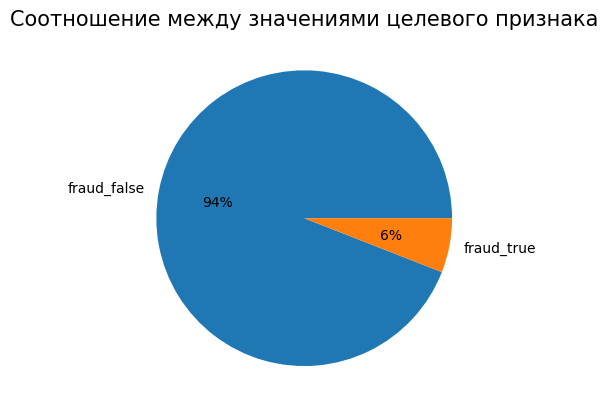

In [7]:
labels = 'fraud_false', 'fraud_true'
sizes = [df_exm['deposit_fraud'].value_counts()[0], df_exm['deposit_fraud'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Соотношение между значениями целевого признака', size=15)
plt.show()

Анализ корреляции между признаками

interval columns not set, guessing: ['deposit_amount_cat', 'deposit_user_time_diff_cat', 'deposit_kyc_time_diff_cat']


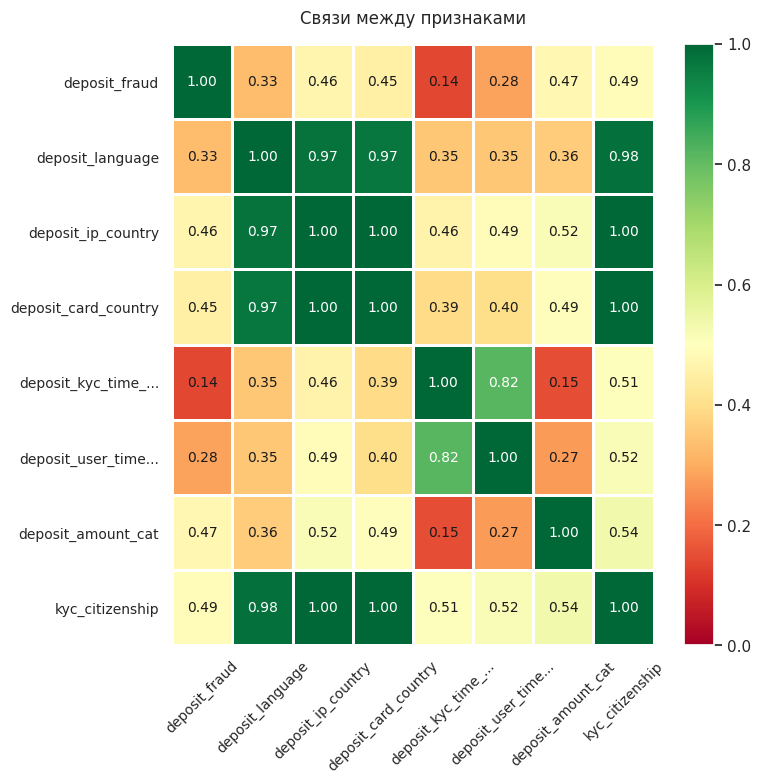

In [8]:
phik_overview = df_exm.drop(columns=['user_id']).phik_matrix()

sns.set()
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1,
                        fontsize_factor=1.0, figsize=(8, 8))
plt.xticks(rotation=45)
plt.title('Связи между признаками', fontsize=12, y=1.02)
plt.tight_layout()

Выводы:
- данные очищены от полных дубликатов строк
- удалены строки с пропусками (они могли повлиять на обучение)
- соотношение классов в целевом признаке - 0.06
- прямой зависимости между целевым признаком и другими не наблюдается

### Полный набор данных

In [9]:
df = pd.read_csv('data/DataSet_full.csv', 
                 parse_dates=['user_created_at', 
                              'kyc_created_at', 
                              'deposit_created_at'])
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27804 entries, 0 to 27803
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  27804 non-null  object        
 1   user_created_at          27804 non-null  datetime64[ns]
 2   user_country_code        27305 non-null  object        
 3   kyc_created_at           27804 non-null  datetime64[ns]
 4   kyc_citizenship          27342 non-null  object        
 5   kyc_permanentcountry     27323 non-null  object        
 6   deposit_id               4507 non-null   object        
 7   deposit_created_at       27804 non-null  datetime64[ns]
 8   deposit_status           27804 non-null  object        
 9   deposit_failure_message  23691 non-null  object        
 10  deposit_amount           14590 non-null  float64       
 11  deposit_currency         14590 non-null  object        
 12  deposit_card_ps          27550 n

,user_id,user_created_at,user_country_code,kyc_created_at,kyc_citizenship,kyc_permanentcountry,deposit_id,deposit_created_at,deposit_status,deposit_failure_message,deposit_amount,deposit_currency,deposit_card_ps,deposit_card_country,deposit_ip,deposit_device,deposit_language,deposit_fraud,deposit_disputed
1625,0e132ff0-723f-4ca5-a7c6-88b445bcd678,2023-10-19 13:13:29.709,AZ,2023-10-19 13:26:31.230676,AZ,AZ,NaN,2023-10-30 09:19:47,FAILED,Card failed 3d secure,NaN,NaN,Visa,TR,"""ipAddress"":""94.228.169.28"",""ipCountry"":""AT""",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,tr,False,False
10560,5a70f5bd-e377-48fa-9177-856609e6d39e,2023-07-30 16:16:15.641,GB,2023-07-30 16:22:39.057711,GB,GB,char_L3wLHrrkmnZwHR8OEwpvnj45,2023-09-21 15:03:23,COMPLETED,NaN,20.0,GBP,MasterCard,GB,"""ipAddress"":""82.132.239.130"",""ipCountry"":""GB""",Mozilla/5.0 (Linux; Android 13; SM-X706B Build...,"en,en-GB;q=0.9,en-US;q=0.8",False,False
3995,21244bf9-677b-43e9-8f5d-90374cecaf7b,2023-08-10 14:59:00.377,UA,2023-08-10 15:11:44.653741,UA,UA,NaN,2023-09-16 13:07:24,FAILED,Card failed 3d secure,NaN,NaN,Visa,IN,"""ipAddress"":""99.253.132.232"",""ipCountry"":""CA""",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,"ca-ES,ca;q=0.9,en-US;q=0.8,en;q=0.7",False,False
15491,89e4baf9-c41a-42ab-8ac3-4efacaac8544,2022-06-02 02:07:40.847,ZW,2023-09-16 12:00:57.785945,ZW,ZW,NaN,2023-09-30 00:04:40,FAILED,Successful liability shift for enrolled card i...,22.0,USD,MasterCard,ZW,"""ipAddress"":""197.221.253.64"",""ipCountry"":""ZW""",Mozilla/5.0 (Linux; Android 11; Nokia C10 Buil...,"en,en-US;q=0.9",False,False
10447,59db52e9-afb6-413e-8c16-2360eef46cae,2021-12-08 15:24:03.495,ZA,2022-04-07 10:16:33.305936,ZA,ZA,NaN,2023-05-16 12:42:46,FAILED,Card failed 3d secure,NaN,NaN,MasterCard,ZA,"""ipAddress"":""197.185.116.201"",""ipCountry"":""ZA""",Mozilla/5.0 (Linux; Android 10; SM-A013G Build...,"en,en-ZA;q=0.9,en-US;q=0.8",NaN,NaN


In [10]:
print(f"количество полных дубликатов строк: {df.duplicated().sum()}")

количество полных дубликатов строк: 1


Удаление полных повторов строк

In [11]:
df = df.drop_duplicates().reset_index(drop=True)

In [12]:
print(f"количество положительных меток целевой переменной: {df['deposit_fraud'].value_counts()[1]}")

количество положительных меток целевой переменной: 144


Создание отдельного датасета  с положительным классом

In [13]:
df_fraud = df[df['deposit_fraud'] == True]
df_fraud.sample(1)

,user_id,user_created_at,user_country_code,kyc_created_at,kyc_citizenship,kyc_permanentcountry,deposit_id,deposit_created_at,deposit_status,deposit_failure_message,deposit_amount,deposit_currency,deposit_card_ps,deposit_card_country,deposit_ip,deposit_device,deposit_language,deposit_fraud,deposit_disputed
24899,e396eb9a-3a07-4c52-96ae-24b5104e9f9d,2023-07-16 15:08:11.049,GB,2023-07-16 17:44:32.816802,US,GB,char_sKtJsrOZd5Xc82A2EQV8hxIn,2023-10-10 13:02:59,COMPLETED,NaN,910.0,GBP,Visa,GB,"""ipAddress"":""147.197.250.34"",""ipCountry"":""GB""",Mozilla/5.0 (iPhone; CPU iPhone OS 14_8_1 like...,en-gb,True,False


In [14]:
print('значения в признаке', df_fraud['deposit_status'].value_counts())
print('значения в признаке', df_fraud['deposit_failure_message'].value_counts())

значения в признаке deposit_status
COMPLETED    139
REFUNDED       5
Name: count, dtype: int64
значения в признаке deposit_failure_message
Several users purchase cryptocurrencies using one card    5
Name: count, dtype: int64


In [15]:
df_fraud[df_fraud['deposit_failure_message'] == 'Several users purchase cryptocurrencies using one card']

,user_id,user_created_at,user_country_code,kyc_created_at,kyc_citizenship,kyc_permanentcountry,deposit_id,deposit_created_at,deposit_status,deposit_failure_message,deposit_amount,deposit_currency,deposit_card_ps,deposit_card_country,deposit_ip,deposit_device,deposit_language,deposit_fraud,deposit_disputed
2285,12dcd7cb-9488-48d8-ae07-c15212df0b20,2023-06-16 18:33:37.325,GB,2023-06-17 01:26:37.528317,GB,GB,char_vEwNP525Exu1u8vrCHOcz0hH,2023-06-17 23:48:48,REFUNDED,Several users purchase cryptocurrencies using ...,950.0,GBP,Visa,GB,"""ipAddress"":""31.14.249.21"",""ipCountry"":""GB""",Mozilla/5.0 (iPhone; CPU iPhone OS 16_5 like M...,"en-US,en;q=0.9",True,False
11305,6161c7a5-8407-42eb-8a69-413e833cb945,2022-09-02 10:43:35.304,GB,2022-09-02 10:52:26.602907,GB,GB,char_Kq1cfsWSpADn9sTq2lDR8vFx,2023-06-22 09:03:17,REFUNDED,Several users purchase cryptocurrencies using ...,970.0,GBP,Visa,GB,"""ipAddress"":""91.74.66.26"",""ipCountry"":""AE""",Mozilla/5.0 (iPhone; CPU iPhone OS 16_5 like M...,"en-GB,en;q=0.9",True,False
15345,88d85a77-a2f8-44da-9c67-9d4e62261f22,2023-06-02 17:41:13.288,GB,2023-06-19 20:22:11.167376,GB,GB,char_AVw3lmwsuVT6yK76uyuF0zey,2023-06-19 19:04:43,REFUNDED,Several users purchase cryptocurrencies using ...,980.0,GBP,Visa,GB,"""ipAddress"":""148.252.132.222"",""ipCountry"":""GB""",Mozilla/5.0 (iPhone; CPU iPhone OS 16_5 like M...,"en-GB,en;q=0.9",True,False
21310,c0fc486c-bb45-40cc-8e8e-8c0d35db17a7,2023-05-31 04:27:31.495,MT,2023-06-03 09:00:01.228178,GB,GB,char_xTI2Y2AiMWevhhsEJf5AeFoC,2023-06-17 10:35:22,REFUNDED,Several users purchase cryptocurrencies using ...,760.0,GBP,Visa,GB,"""ipAddress"":""31.14.249.21"",""ipCountry"":""GB""",Mozilla/5.0 (iPhone; CPU iPhone OS 15_6_1 like...,"en-GB,en;q=0.9",True,False
27346,f93e24d1-2642-4a84-8a7a-2acade0f2996,2023-06-06 22:06:53.998,GB,2023-06-07 08:39:14.226483,IT,GB,char_hTpSPr8n38sLGt2lyOwA9FYt,2023-06-18 23:05:58,REFUNDED,Several users purchase cryptocurrencies using ...,980.0,GBP,Visa,GB,"""ipAddress"":""31.14.249.21"",""ipCountry"":""GB""",Mozilla/5.0 (iPhone; CPU iPhone OS 16_3_1 like...,"en-GB,en;q=0.9",True,False


Создание дополнительных признаков

In [16]:
df['user_kyc_created_diff'] = (df['kyc_created_at'] - df['user_created_at']).dt.total_seconds()
df['deposit_kyc_created_diff'] = (df['deposit_created_at'] - df['kyc_created_at']).dt.total_seconds()
df['third_party_card'] = (
    df['deposit_failure_message']
    .apply(lambda x: 1 if x == 'Several users purchase cryptocurrencies using one card' else 0))
df['deposit_ip_country_code'] = (
    df['deposit_ip']
    .apply(lambda x: x.split('"ipCountry":"')[1].strip('"') if '"ipCountry":"' in x else ''))
df['language_code'] = (
    df['deposit_language']
    .apply(lambda x: x.split(',')[0].split('-')[0].strip() if isinstance(x, str) else ''))
# The charge is suspected to be fraudulen, 
# Certain fraud score is reached, 
# The card is marked as lost or stolen
# The card is blacklisted

Удаление ненужных признаков

In [17]:
df = df.drop(['deposit_disputed', 
              'deposit_status', 
              'user_created_at', 
              'kyc_created_at', 
              'deposit_id', 
              'deposit_created_at', 
              'deposit_ip', 
              'deposit_failure_message', 
              'deposit_device', 
              'deposit_language'], 
             axis=1)

Удаление пропущенных значений

In [18]:
df = df.dropna(subset=['deposit_fraud', 
                       'deposit_amount', 
                       'deposit_card_country', 
                       'user_country_code'])
# вместо 144 остаётся 135 меток

Изменение типов данных

In [19]:
df['deposit_fraud'] = df['deposit_fraud'].astype(bool)

Заполнение пропущенных значений

In [20]:
df['deposit_card_ps'] = df['deposit_card_ps'].fillna('unknown')

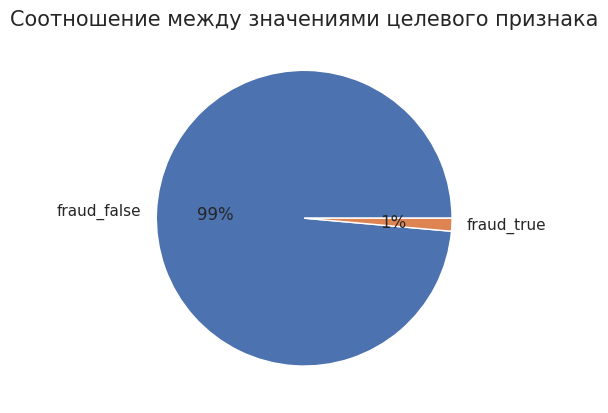

deposit_fraud
False    9445
True      135
Name: count, dtype: int64

In [21]:
sizes = [df['deposit_fraud'].value_counts()[0], df['deposit_fraud'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.0f%%')
plt.title('Соотношение между значениями целевого признака', size=15)
plt.show()
df['deposit_fraud'].value_counts()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9580 entries, 0 to 27801
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   9580 non-null   object 
 1   user_country_code         9580 non-null   object 
 2   kyc_citizenship           9580 non-null   object 
 3   kyc_permanentcountry      9580 non-null   object 
 4   deposit_amount            9580 non-null   float64
 5   deposit_currency          9580 non-null   object 
 6   deposit_card_ps           9580 non-null   object 
 7   deposit_card_country      9580 non-null   object 
 8   deposit_fraud             9580 non-null   bool   
 9   user_kyc_created_diff     9580 non-null   float64
 10  deposit_kyc_created_diff  9580 non-null   float64
 11  third_party_card          9580 non-null   int64  
 12  deposit_ip_country_code   9580 non-null   object 
 13  language_code             9580 non-null   object 
dtypes: bool(1), 

Выводы:
- данные очищены от полных дубликатов строк
- количество меток положительного класса в целевой переменной - 144
- удалён признак `deposit_disputed`, т.к. требуется заранее определять <br>мошеннические операции, и данный признак не подходит по определению
- признак `deposit_status` не несёт информации, <br>т.к. практически все фродовые депозиты с одним статусом
- в признаке `deposit_failure_message` скрыт триггер, однозначно указывающий на фрод
- созданы дополнительные признаки
- удалены ненужные признаки
- обработаны (удалены и заменены) пропущенные значения

## Data preparation

Фиксация констант

In [23]:
RS = 42
cat_features_base = ['kyc_citizenship', 
                     'deposit_card_country', 
                     'deposit_ip_country', 
                     'deposit_language']
cat_features_main = ['user_country_code', 
                     'kyc_citizenship', 
                     'kyc_permanentcountry', 
                     'deposit_currency', 
                     'deposit_card_ps', 
                     'deposit_card_country', 
                     'deposit_ip_country_code', 
                     'language_code']

Функция для кодирования данных, чтобы привести их к виду, <br>подходящему для обучения линейной модели

In [24]:
def data_encoding(X_data, cat_features, model):
    '''
    - на вход принимает датасет признаков без целевого,
      список категориальных признаков, и название модели
    - производит кодирование нечисловых категориальных признаков
    - производит масшатбирование всех числовых признаков
    - возвращает новый датасет
    '''
    if model == 'CatBoost':
        scaler_cb = MinMaxScaler(feature_range=(0, 1))
        X_data_es = (pd.DataFrame(
            scaler_cb.fit_transform(X_data.drop(cat_features_main, axis=1).drop('user_id', axis=1)),
            columns=X_data.drop(cat_features_main, axis=1).drop('user_id', axis=1).columns,
            index=X_data.index)
                    )
        X_data_es = (X_data[cat_features_main]
                 .merge(X_data_es, 
                        how='left', 
                        left_index=True, 
                        right_index=True, 
                        sort=False)
                )
    else:
        encoder = OrdinalEncoder()
        X_data_oe = (pd.DataFrame(
            encoder.fit_transform(X_data[cat_features]), 
            columns=cat_features, 
            index=X_data.index)
                    )
        X_data_oe = (X_data.drop(cat_features, axis=1)
                     .merge(X_data_oe, 
                            how='left', 
                            left_index=True, 
                            right_index=True, 
                            sort=False)
                    )
        scaler = StandardScaler()
        X_data_es = (pd.DataFrame(
            scaler.fit_transform(X_data_oe.drop(['user_id'], axis=1)), 
            columns=X_data_oe.drop(['user_id'], axis=1).columns, 
            index=X_data_oe.index)
                    )
    
    return X_data_es

### Тренировочный набор данных

Выделение целевого признака

In [25]:
X_base = df_exm.drop(['deposit_fraud'], axis=1)
y_base = df_exm['deposit_fraud']
X_base.shape, y_base.shape

((2288, 8), (2288,))

Кодирование данных

In [26]:
X_base_es = data_encoding(X_base, cat_features_base, 'Logistic Regression')
X_base_es.shape

(2288, 7)

Разделение на обучающую и тестовую выборки

In [27]:
X_base_train, X_base_test, y_base_train, y_base_test = (
    train_test_split(X_base_es, 
                     y_base, 
                     test_size=0.2, 
                     random_state=RS, 
                     stratify=y_base)
)
X_base_train.shape, X_base_test.shape, y_base_train.shape, y_base_test.shape

((1830, 7), (458, 7), (1830,), (458,))

### Полный набор данных

Выделение целевого признака

In [28]:
X = df.drop(['deposit_fraud'], axis=1)
y = df['deposit_fraud']
X.shape, y.shape

((9580, 13), (9580,))

Данные для CatBoost

In [29]:
X_cb = data_encoding(X, cat_features_main, 'CatBoost')
X_train_cb, X_test_cb, y_train_cb, y_test_cb = (
    train_test_split(X_cb, 
                     y, 
                     test_size=0.2, 
                     random_state=RS, 
                     stratify=y)
)
X_train_cb.shape, X_test_cb.shape, y_train_cb.shape, y_test_cb.shape

((7664, 12), (1916, 12), (7664,), (1916,))

Разделение на обучающую и тестовую выборки

In [30]:
X_es = data_encoding(X, cat_features_main, 'Logistic Regression')
X_train, X_test, y_train, y_test = (train_test_split(X_es, 
                                                     y, 
                                                     test_size=0.2, 
                                                     random_state=RS, 
                                                     stratify=y)
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7664, 12), (1916, 12), (7664,), (1916,))

## Modeling

### Baseline (Logistic Regression)

ROC-AUC на тестовой выборке: 0.79


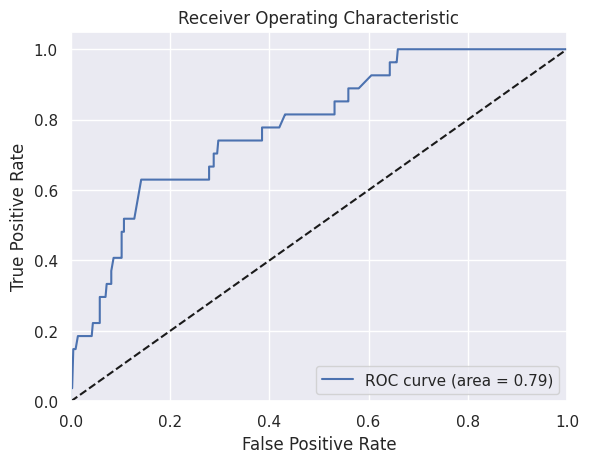

In [31]:
baseline = LogisticRegression(random_state=RS, max_iter=1000)
baseline.fit(X_base_train.values, y_base_train)

# Вычисление ROC-AUC
y_pred_base = baseline.predict_proba(X_base_test.values)[:, 1]
roc_auc_baseline = roc_auc_score(y_base_test, y_pred_base)
print(f"ROC-AUC на тестовой выборке: {round(roc_auc_baseline, 2)}")

# Визуализация кривой ROC
fpr_lg, tpr_lg, thresholds_lg = roc_curve(y_base_test, y_pred_base)
plt.plot(fpr_lg, tpr_lg, label='ROC curve (area = %0.2f)' % roc_auc_baseline)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression

ROC-AUC на тестовой выборке: 0.89


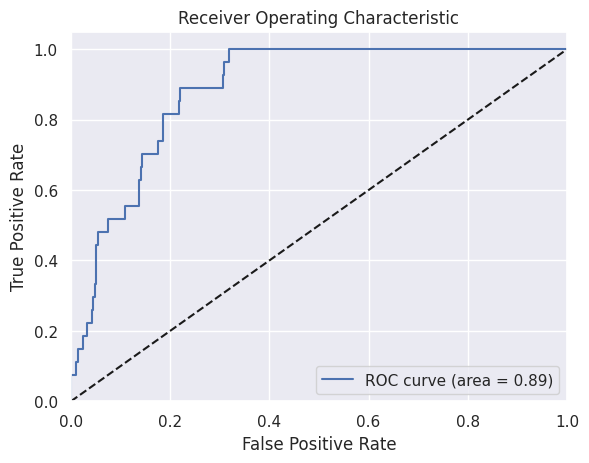

In [32]:
logreg = LogisticRegression(random_state=RS, max_iter=1000)
logreg.fit(X_train.values, y_train)

# Вычисление ROC-AUC
y_pred_lr = logreg.predict_proba(X_test.values)[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_pred_lr)
print(f"ROC-AUC на тестовой выборке: {round(roc_auc_lr, 2)}")

# Визуализация кривой ROC
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_pred_lr)
plt.plot(fpr_log, tpr_log, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### CatBoost

In [33]:
cbst = CatBoostClassifier(random_state=RS, cat_features=cat_features_main, eval_metric='AUC')
cbst.fit(X_train_cb, y_train_cb, eval_set=(X_test_cb, y_test_cb), verbose=100, plot=True)

y_pred_proba_cb = cbst.predict_proba(X_test_cb)[:, 1]
roc_auc_cbst = roc_auc_score(y_test, y_pred_proba_cb)
print("ROC-AUC на тестовой выборке:", roc_auc_cbst)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.052405
0:	test: 0.6199733	best: 0.6199733 (0)	total: 363ms	remaining: 6m 2s
100:	test: 0.9452385	best: 0.9456503 (78)	total: 14.7s	remaining: 2m 11s
200:	test: 0.9422975	best: 0.9461796 (102)	total: 17s	remaining: 1m 7s
300:	test: 0.9443954	best: 0.9462581 (254)	total: 19.5s	remaining: 45.3s
400:	test: 0.9442974	best: 0.9462581 (254)	total: 21.1s	remaining: 31.6s
500:	test: 0.9429249	best: 0.9462581 (254)	total: 22.6s	remaining: 22.5s
600:	test: 0.9422975	best: 0.9462581 (254)	total: 23.8s	remaining: 15.8s
700:	test: 0.9405133	best: 0.9462581 (254)	total: 25.1s	remaining: 10.7s
800:	test: 0.9404937	best: 0.9462581 (254)	total: 26.5s	remaining: 6.59s
900:	test: 0.9381997	best: 0.9462581 (254)	total: 28s	remaining: 3.07s
999:	test: 0.9373958	best: 0.9462581 (254)	total: 29.3s	remaining: 0us

bestTest = 0.9462580633
bestIteration = 254

Shrink model to first 255 iterations.
ROC-AUC на тестовой выборке: 0.9462580632511812


## Feature importance

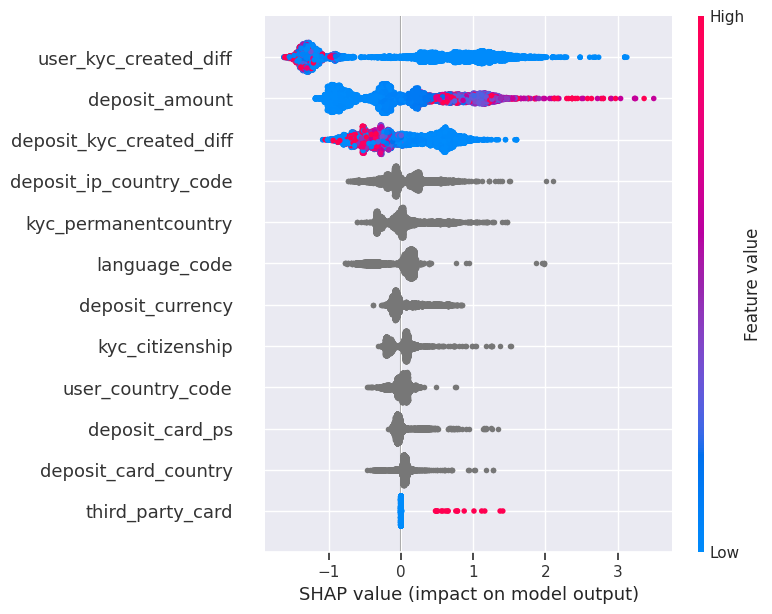

In [34]:
explainer = shap.TreeExplainer(cbst, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_train_cb)
shap.summary_plot(shap_values, X_train_cb)

## Pivot table

In [35]:
dict_sum = {'Baseline': [roc_auc_baseline],
         'Logistic Regression': [roc_auc_lr],
         'Catboost': [roc_auc_cbst]}
summary_data = (pd.DataFrame.from_dict(dict_sum, orient='index',
                                      columns=["roc-auc"]).reset_index()
                                      .rename(columns={'index': 'model'})
                                      )
summary_data

,model,roc-auc
0,Baseline,0.785641
1,Logistic Regression,0.885869
2,Catboost,0.946258


## Заключение
- для полноценного обучения модели нужна информация о картах (маскированный номер)
- нужно больше размеченных данных с положительным классом
- в ходе исследования были обучены две модели:
  - логистическая регрессия, показавшая результат `roc-auc=0.89`
  - модель бустинга, показавшая результат `roc-auc=0.95`
- для определения важности признаков использована библиотека `shap`,
  <br>выявившая наиболее важными признаками для модели:
  - размер депозита
  - разницу между датой регистрации пользователя и датой kyc
  - разницу между датой kyc и датой депозита
  - метку использования одной карты разными пользователями